In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image

batch_size = 128
latent_size = 64
image_size = 784 # 28*28
hidden_size = 256


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(device)

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [3]:
## Import Fashion MNIST dataset
image_transforms = transforms.Compose([ transforms.ToTensor(),
                                        transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=image_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
print("Number of training batches:", len(trainloader), "of batch_size:", batch_size)

Number of training batches: 468 of batch_size: 128


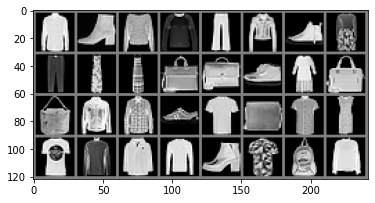

In [4]:
#display a grid of images from trainset#
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images[:32]))

In [5]:
#Generative model G
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(latent_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, image_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.tanh(self.fc3(x))
        return x
    
# Discriminative model D
class Discriminator(nn.Module):
    #1 for real, 0 for generated
    """Output represents probability of image being real(as opposed to fake)."""
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(image_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

generator = Generator().to(device)
discriminator = Discriminator().to(device)

images = next(iter(trainloader))[0].view(batch_size, -1).to(device)
print(images.shape, discriminator(images).shape)

noise = torch.randn(batch_size, latent_size).to(device)
print(noise.shape, generator(noise).shape)

print(sum(p.numel() for p in generator.parameters() if p.requires_grad), sum(p.numel() for p in discriminator.parameters() if p.requires_grad)  )
print(discriminator(generator(noise)).shape)

torch.Size([128, 784]) torch.Size([128, 1])
torch.Size([128, 64]) torch.Size([128, 784])
283920 267009
torch.Size([128, 1])


In [6]:
# delete folder generated with everyhing in it
import shutil
shutil.rmtree('generated')
!mkdir generated

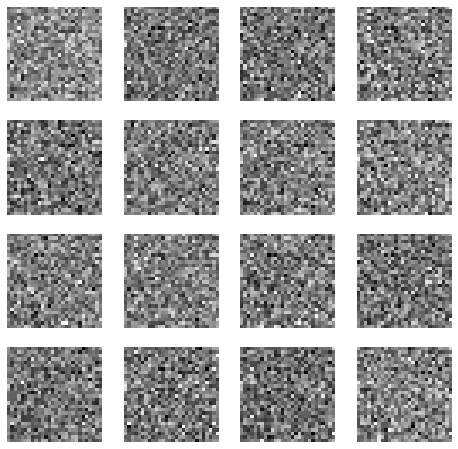

In [9]:
#display generated images
def display_generated_images(generator, image_num=-1):
    noise = torch.randn(32, latent_size, device=device)
    with torch.no_grad():
        generated_images = generator(noise).detach().cpu()

    #denormalize generated images
    generated_images = generated_images * 0.5 + 0.5
    generated_images = generated_images.view(32, 1, 28, 28).clamp(0, 1)
    # display generated images using matplotlib
    fig = plt.figure(figsize=(8, 8))
    for i in range(16):
        ax = fig.add_subplot(4, 4, i+1)
        ax.imshow(generated_images[i].squeeze(), cmap='gray')
        ax.axis('off')
    if image_num !=-1: plt.savefig(f'generated/{image_num}.png')
    if image_num % 5 == 0: plt.show()
    
display_generated_images(generator)

Epoch 0 Generator loss 4.9769 Discriminator loss 0.0640


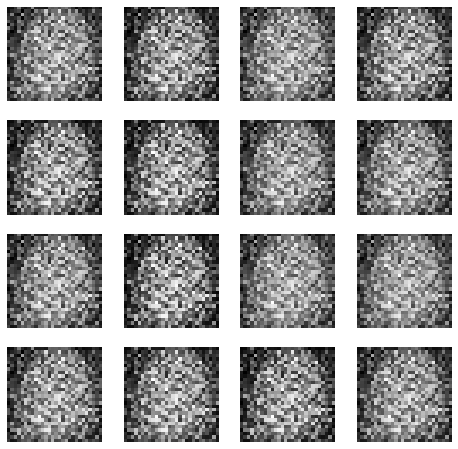

Epoch 1 Generator loss 4.6463 Discriminator loss 0.0189
Epoch 2 Generator loss 4.9869 Discriminator loss 0.0602
Epoch 3 Generator loss 7.0249 Discriminator loss 0.0229
Epoch 4 Generator loss 6.8258 Discriminator loss 0.0196
Epoch 5 Generator loss 6.0310 Discriminator loss 0.1381


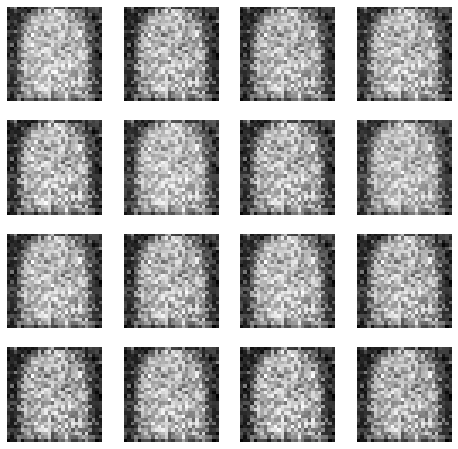

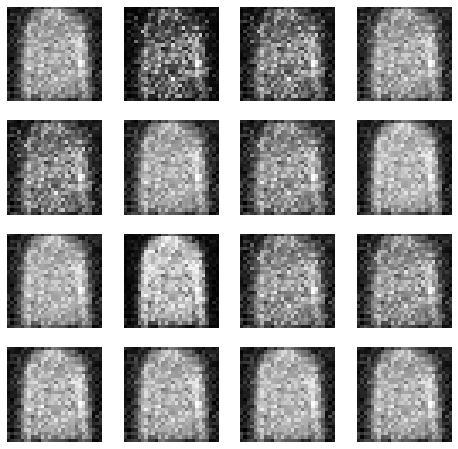

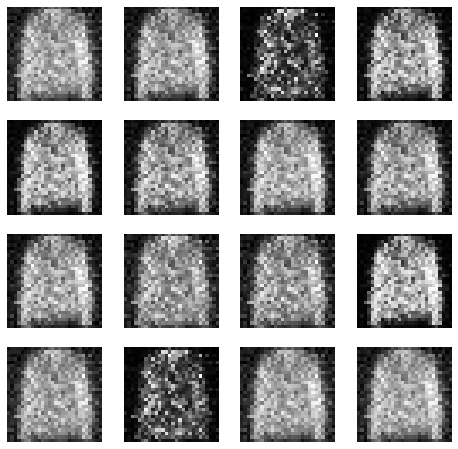

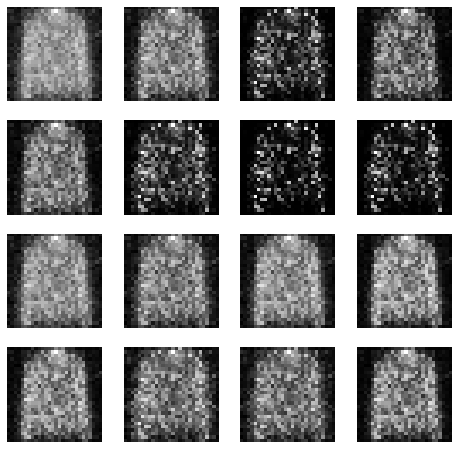

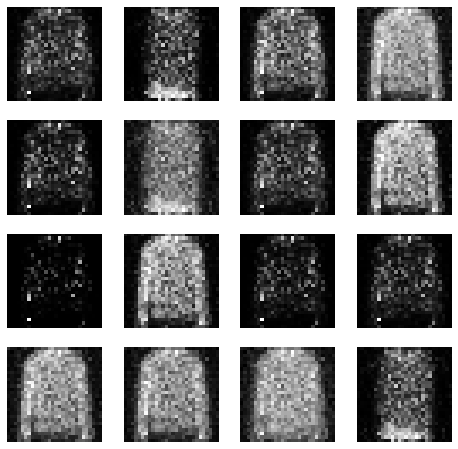

Epoch 6 Generator loss 4.4328 Discriminator loss 0.0628
Epoch 7 Generator loss 3.9718 Discriminator loss 0.1176
Epoch 8 Generator loss 5.3463 Discriminator loss 0.1369
Epoch 9 Generator loss 6.3612 Discriminator loss 0.3843
Epoch 10 Generator loss 4.6149 Discriminator loss 0.2425


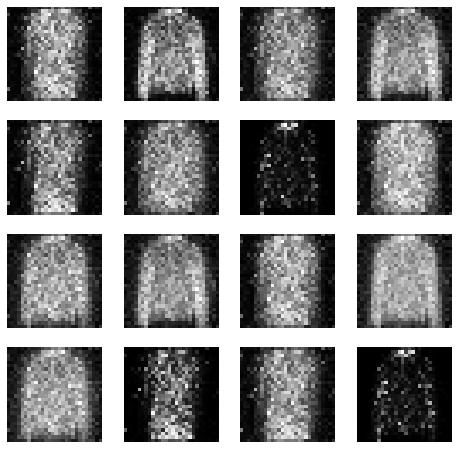

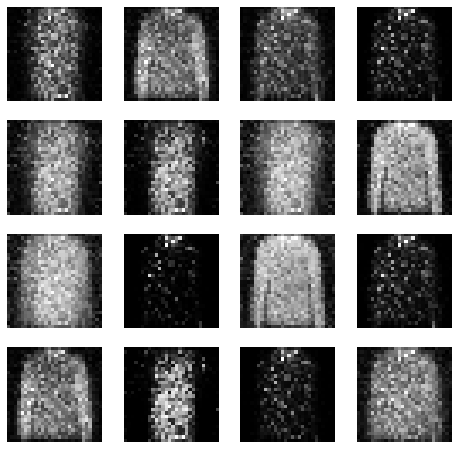

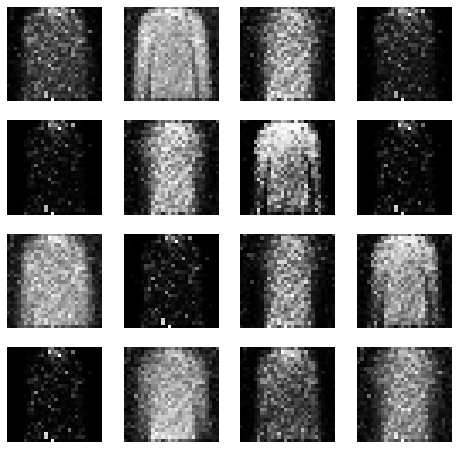

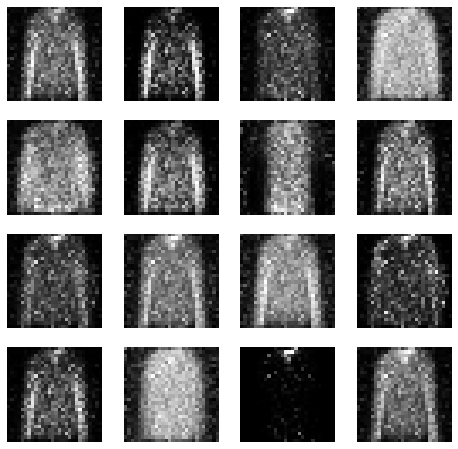

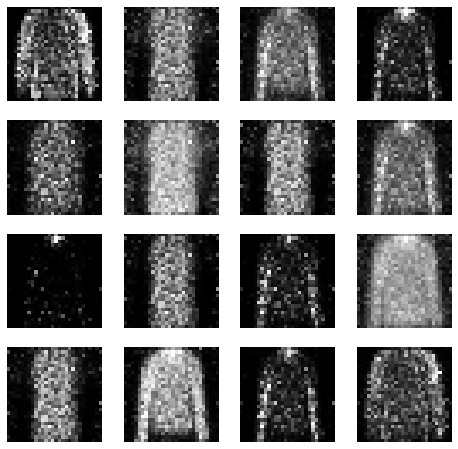

Epoch 11 Generator loss 4.8914 Discriminator loss 0.1069
Epoch 12 Generator loss 4.4667 Discriminator loss 0.2280
Epoch 13 Generator loss 5.3450 Discriminator loss 0.4498
Epoch 14 Generator loss 4.0810 Discriminator loss 0.2973
Epoch 15 Generator loss 5.2390 Discriminator loss 0.1201


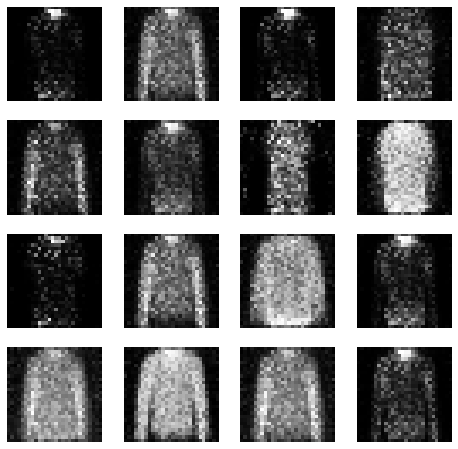

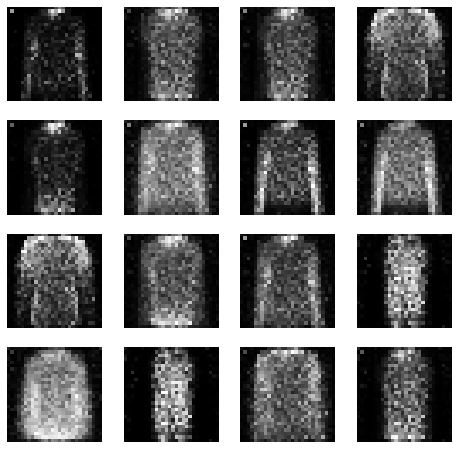

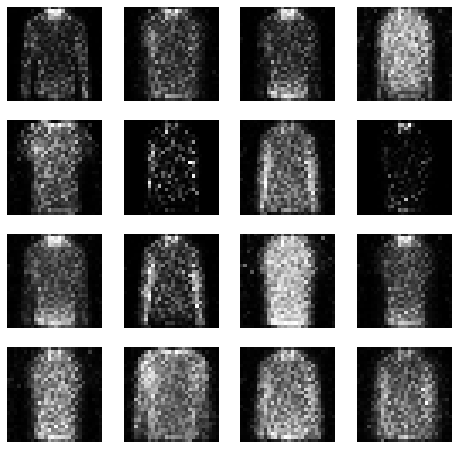

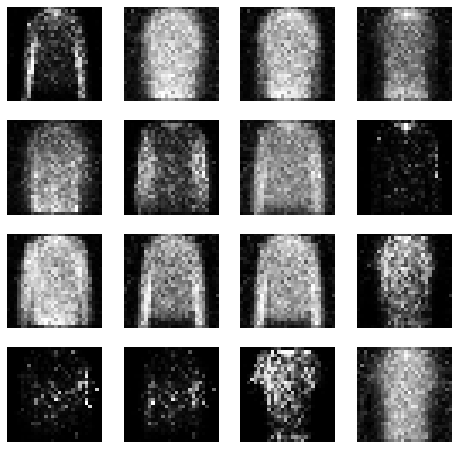

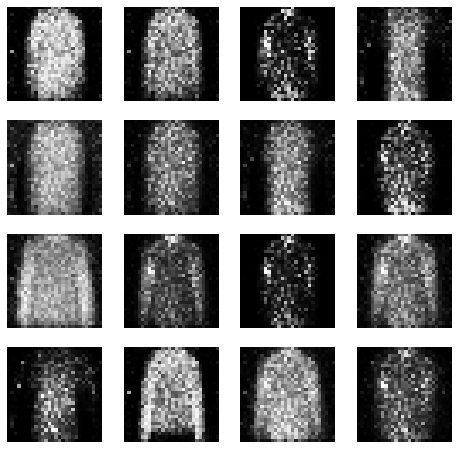

Epoch 16 Generator loss 4.3650 Discriminator loss 0.1483
Epoch 17 Generator loss 4.0008 Discriminator loss 0.4925
Epoch 18 Generator loss 5.7918 Discriminator loss 0.2953
Epoch 19 Generator loss 3.3059 Discriminator loss 0.4455
Epoch 20 Generator loss 3.4506 Discriminator loss 0.2621


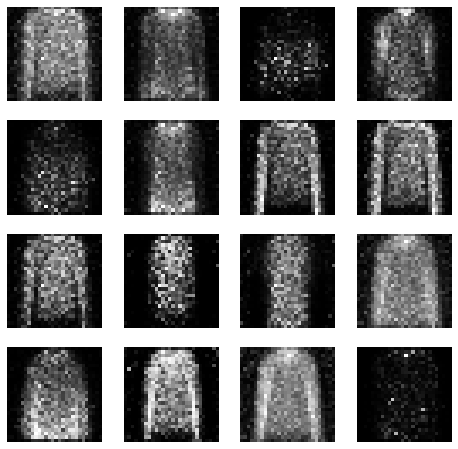

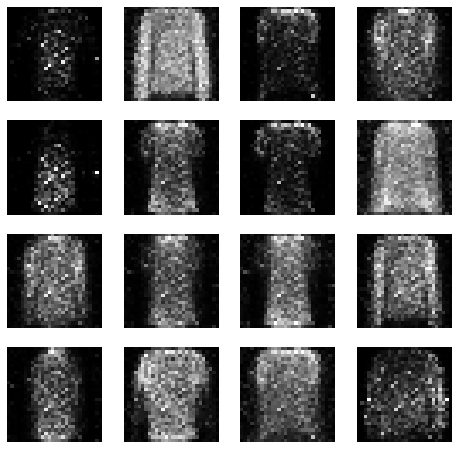

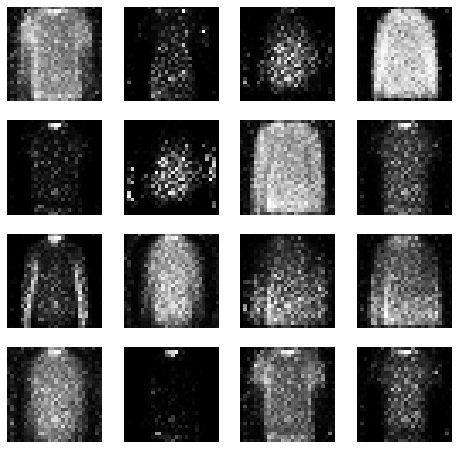

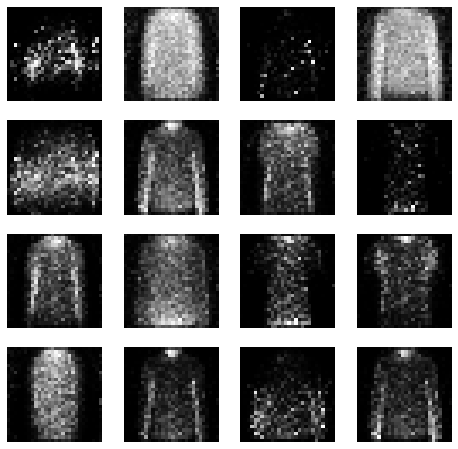

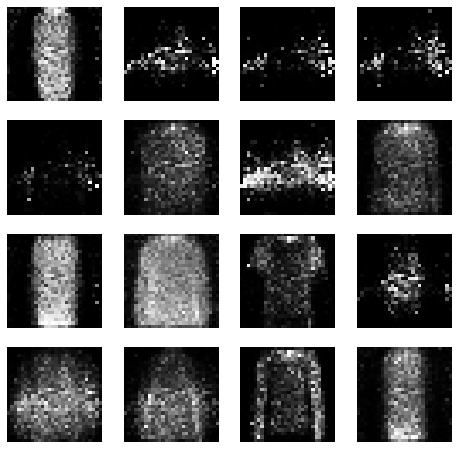

Epoch 21 Generator loss 4.5090 Discriminator loss 0.2138
Epoch 22 Generator loss 3.9006 Discriminator loss 0.2336
Epoch 23 Generator loss 3.5466 Discriminator loss 0.3160
Epoch 24 Generator loss 3.2026 Discriminator loss 0.4585
Epoch 25 Generator loss 4.4129 Discriminator loss 0.1885


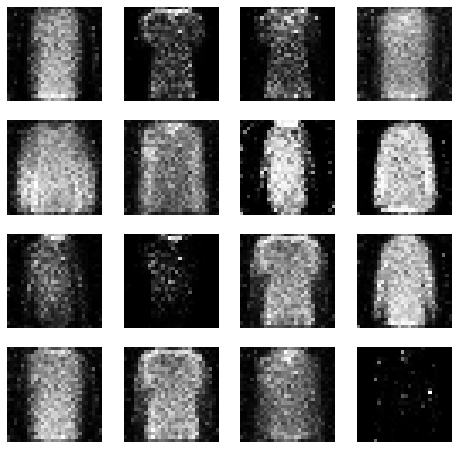

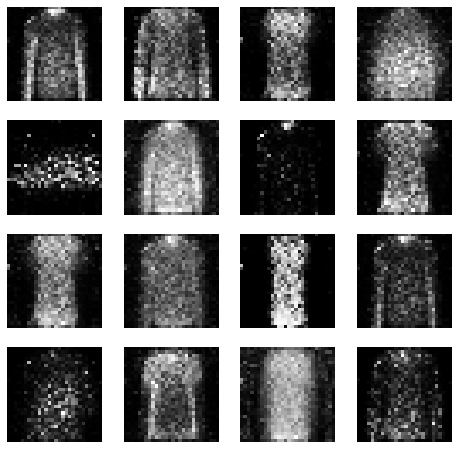

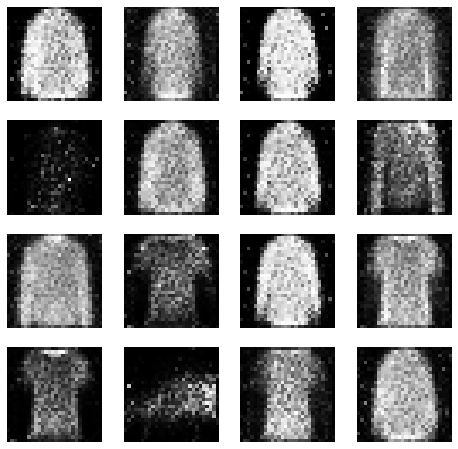

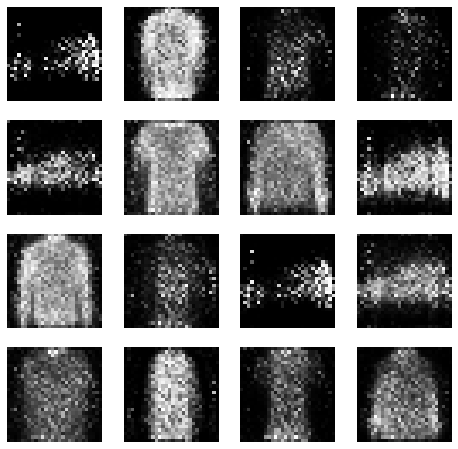

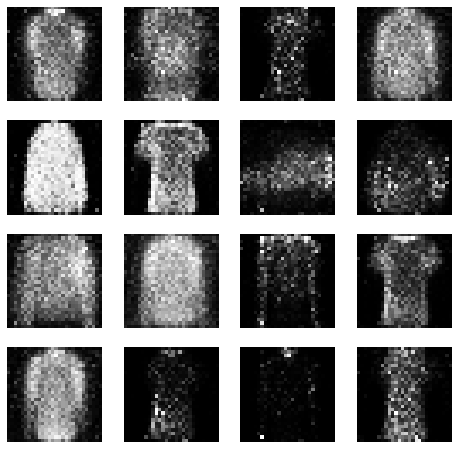

Epoch 26 Generator loss 3.2309 Discriminator loss 0.3892
Epoch 27 Generator loss 3.4059 Discriminator loss 0.2909
Epoch 28 Generator loss 3.5799 Discriminator loss 0.4169
Epoch 29 Generator loss 3.2187 Discriminator loss 0.5230
Epoch 30 Generator loss 2.9100 Discriminator loss 0.5466


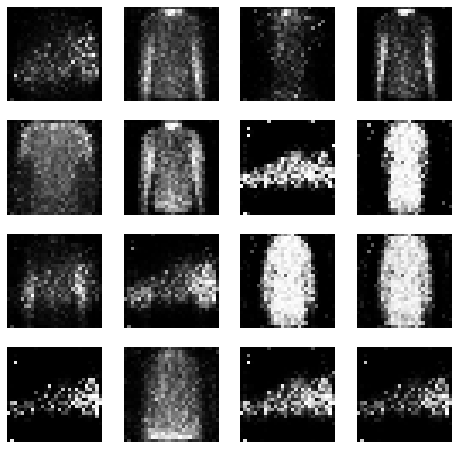

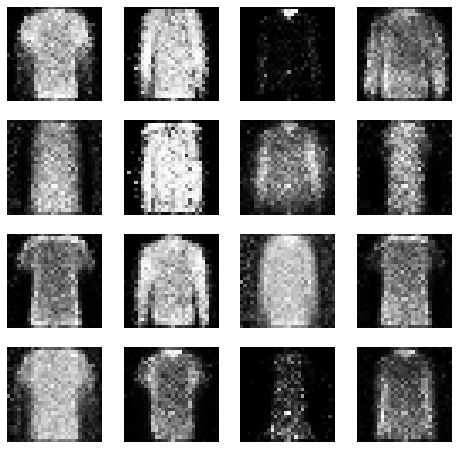

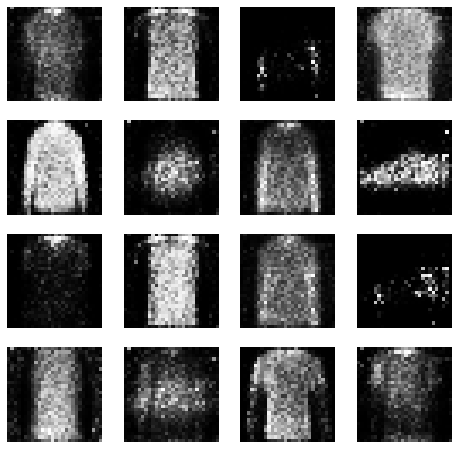

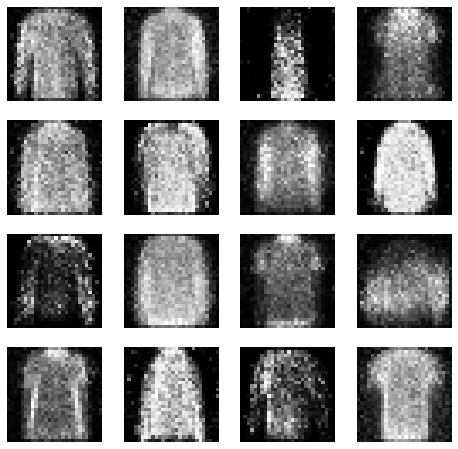

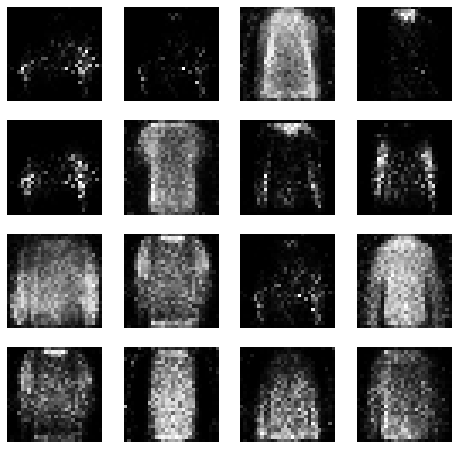

Epoch 31 Generator loss 3.5239 Discriminator loss 0.4203
Epoch 32 Generator loss 3.0584 Discriminator loss 0.3348
Epoch 33 Generator loss 3.7997 Discriminator loss 0.5659
Epoch 34 Generator loss 2.8870 Discriminator loss 0.5546
Epoch 35 Generator loss 2.5661 Discriminator loss 0.5073


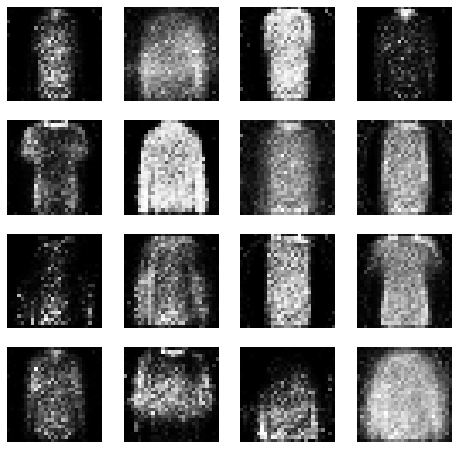

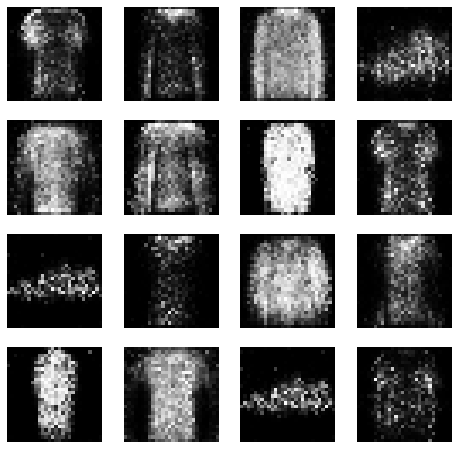

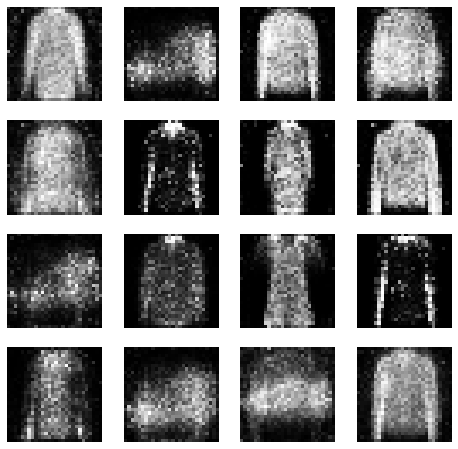

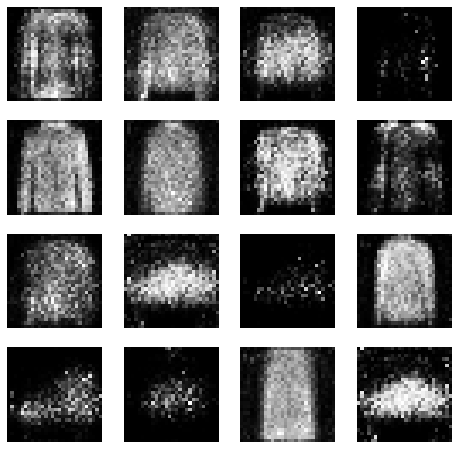

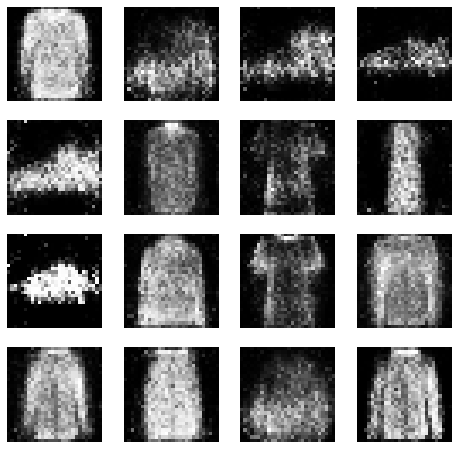

Epoch 36 Generator loss 2.8720 Discriminator loss 0.5973
Epoch 37 Generator loss 2.8640 Discriminator loss 0.5082
Epoch 38 Generator loss 2.2301 Discriminator loss 0.7517
Epoch 39 Generator loss 3.7675 Discriminator loss 0.5066
Epoch 40 Generator loss 4.0032 Discriminator loss 0.5618


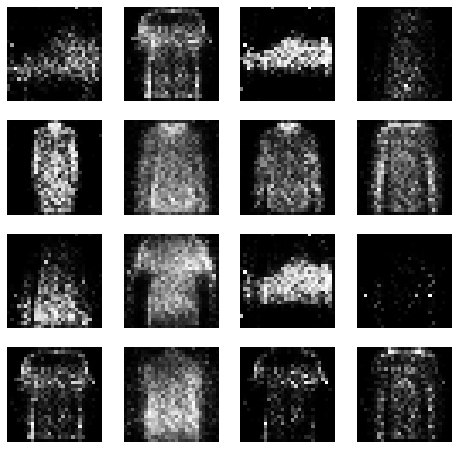

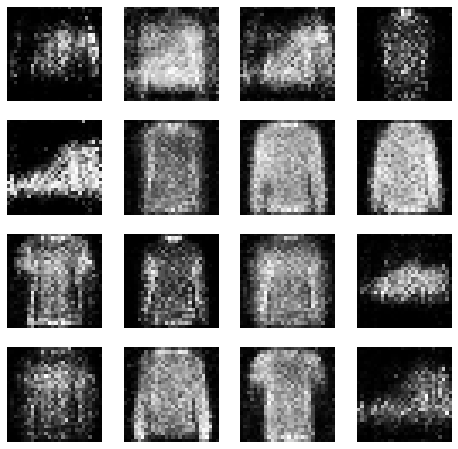

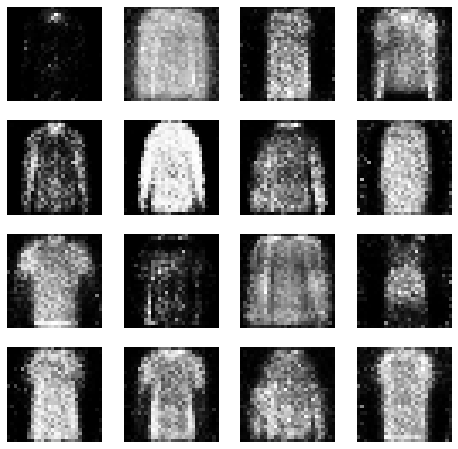

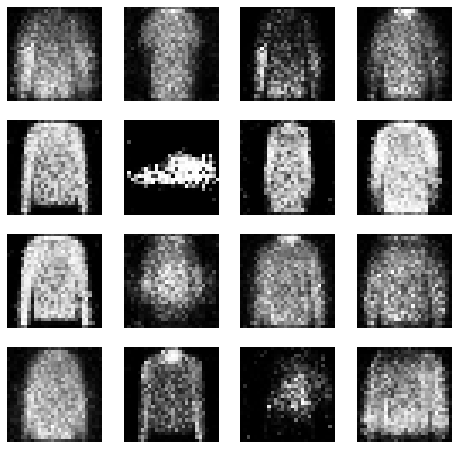

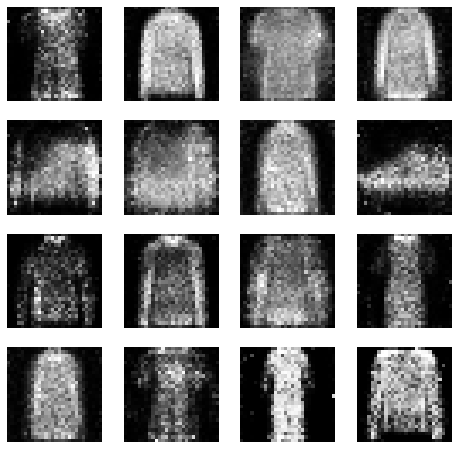

Epoch 41 Generator loss 2.8937 Discriminator loss 0.3606
Epoch 42 Generator loss 3.1773 Discriminator loss 0.4726
Epoch 43 Generator loss 3.6475 Discriminator loss 0.4809
Epoch 44 Generator loss 3.1262 Discriminator loss 0.5625
Epoch 45 Generator loss 3.7193 Discriminator loss 0.5391


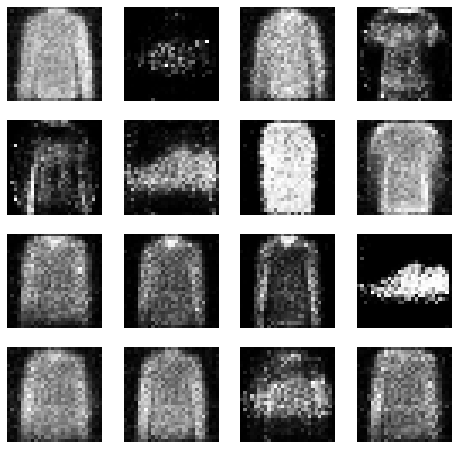

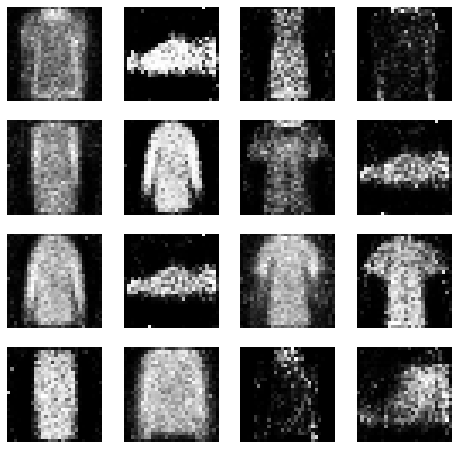

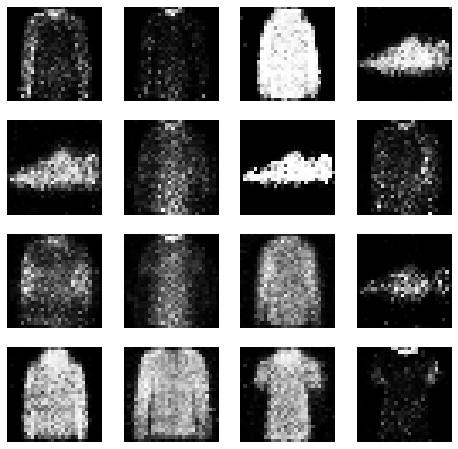

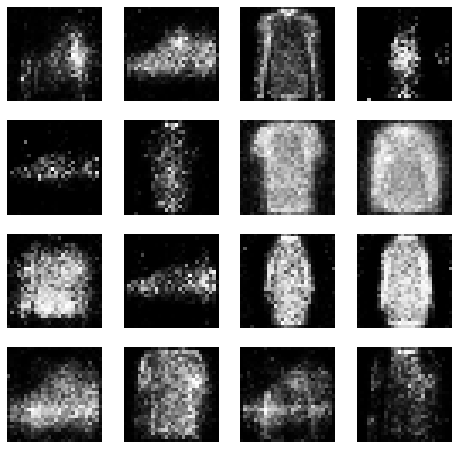

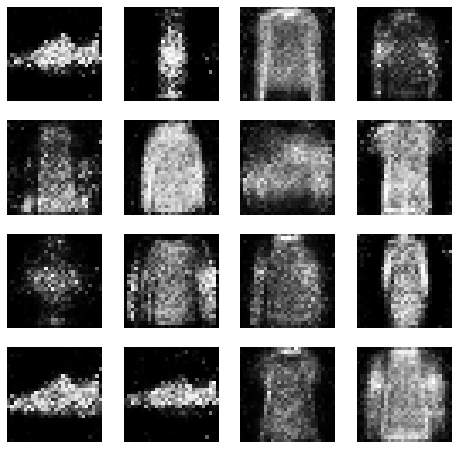

Epoch 46 Generator loss 2.9970 Discriminator loss 0.5160
Epoch 47 Generator loss 3.5322 Discriminator loss 0.3026
Epoch 48 Generator loss 2.7901 Discriminator loss 0.4149
Epoch 49 Generator loss 3.0797 Discriminator loss 0.4217


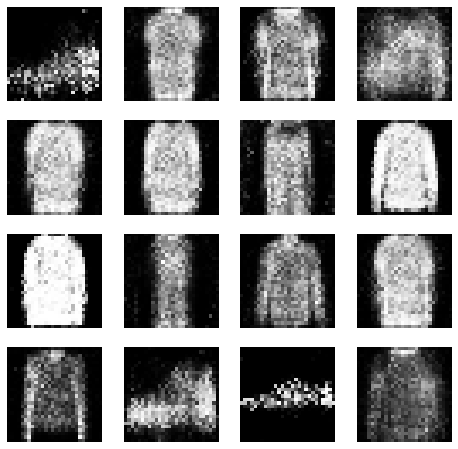

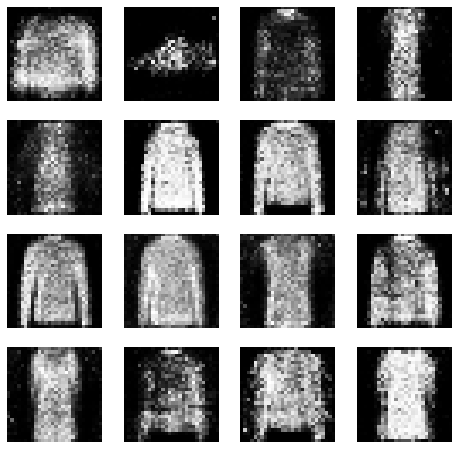

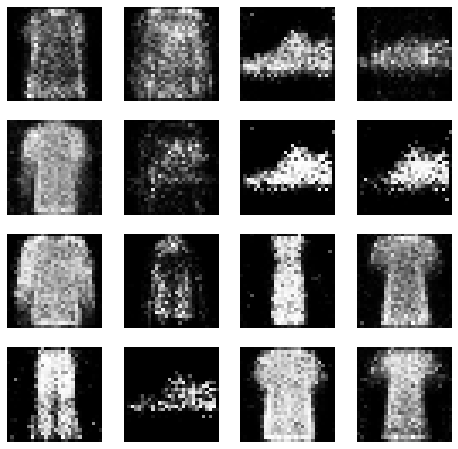

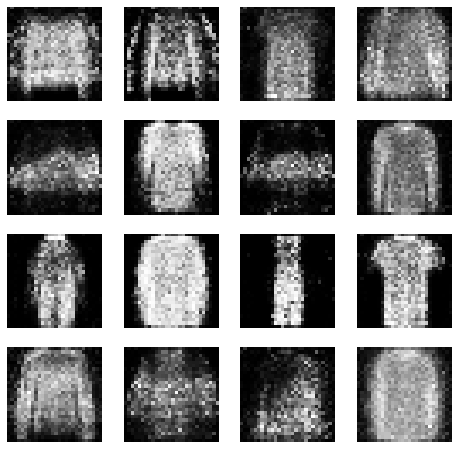

In [10]:
epochs = 50
learning_rate = 2e-4

loss_fn = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)

image_num = 0
for epoch in range(epochs):
    for i , (images, _) in enumerate(trainloader):
        
        real_images = images.view(batch_size, -1).to(device)
        
        discriminator_noise = torch.randn(batch_size, latent_size).to(device)
        generator_noise = torch.randn(batch_size, latent_size).to(device)
        
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # print("-"*50)
        # print("real_images", real_images.shape)
        # print("discriminator_noise", discriminator_noise.shape, "generator_noise", generator_noise.shape)
        # print("real_labels", real_labels.shape, "fake_labels", fake_labels.shape)

        ########## Train Discriminator ##########

        #train discriminator on real images
        pred_labels_real = discriminator(real_images)
        real_loss = loss_fn(pred_labels_real, real_labels)

        #train discriminator on fake images
        fake_images_1 = generator(discriminator_noise)
        pred_labels_fake = discriminator(fake_images_1)
        fake_loss = loss_fn(pred_labels_fake, fake_labels)

        discriminator_loss = real_loss + fake_loss
        
        # print("\nDiscriminator loss", discriminator_loss)
        # print("real_loss", real_loss, "fake_loss", fake_loss)
        # print("pred_labels_real", pred_labels_real.shape, "pred_labels_fake", pred_labels_fake.shape)


        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        discriminator_loss.backward()
        d_optimizer.step()
        
        ########## Train Generator ##########

        fake_images_2 = generator(generator_noise)
        pred_labels_fake_2 = discriminator(fake_images_2)
        generator_loss = loss_fn(pred_labels_fake_2, real_labels)
        
        # print("\nGenerator loss", generator_loss)
        # print("fake_images_2", fake_images_2.shape)
        # print("pred_labels_fake_2", pred_labels_fake_2.shape)

        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        generator_loss.backward()
        g_optimizer.step()

    print(f"Epoch {epoch} Generator loss {generator_loss:.4f} Discriminator loss {discriminator_loss:.4f}")
    display_generated_images(generator, image_num = image_num)
    image_num += 1


Saved at generated/generated.gif


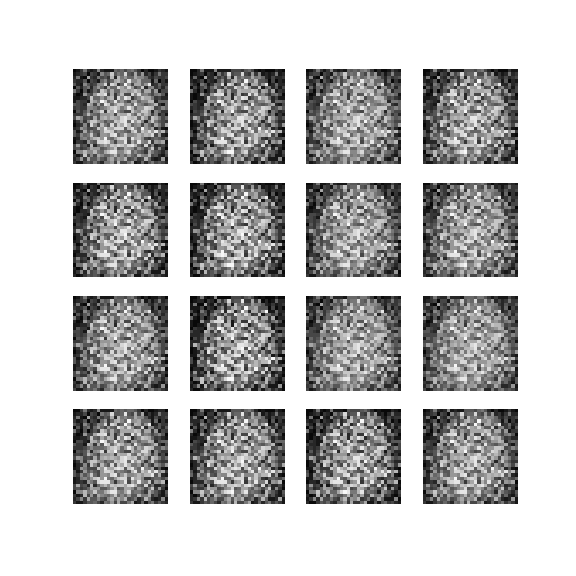

In [26]:
# create a gif of the images without using imageio
import os
import glob
import contextlib
from PIL import Image

# filepaths
fp_in = "generated/*.png"
fp_out = "generated/generated.gif"

# use exit stack to automatically close opened images
with contextlib.ExitStack() as stack:

        # filepaths = sorted(glob.glob(fp_in))[:10]
        filepaths = [f"generated/{i}.png" for i in range(50)][::5]
        # lazily load images
        imgs = (stack.enter_context(Image.open(f))
                for f in filepaths)
        

        # extract  first image from iterator
        img = next(imgs)

        # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
        img.save(fp=fp_out, format='GIF', append_images=imgs,
                save_all=True, duration=1000, loop=0)

        print(f"Saved at {fp_out}")

#display the gif
from IPython.display import Image
Image(filename='generated/generated.gif')

In [ ]:
#take every 5th element in list l
l = [1,2,3,4,5,6,7,8,9,10]
l[::5]